Some trials about chunking !

In [1]:
import sys
sys.path.append('../')
from utils import read_file
from datasets import load_dataset

from llama_index.core import Document
from llama_index.core.node_parser import SentenceSplitter

#load data
def load_wiki_data():
    ds = load_dataset("Salesforce/wikitext", "wikitext-103-raw-v1")
    data = read_file(ds["train"]['text'])
    return data

/mnt/nvme/home/durech/camille/rag/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = load_wiki_data()

### Semantic chunking

In [3]:
# load embedding model
from langchain_community.embeddings import HuggingFaceBgeEmbeddings
hf = HuggingFaceBgeEmbeddings(
            model_name="w601sxs/b1ade-embed"
        )

No sentence-transformers model found with name w601sxs/b1ade-embed. Creating a new one with MEAN pooling.


In [4]:
from semantic_chunking import chunk_text, plot_chunking
 #use semantic chunking to split 2 articles
distances, sentences, chunks, max_index_split = chunk_text (data[0:2],pattern = r'\s\.\s')

Matplotlib created a temporary cache directory at /tmp/matplotlib-fbs8c15z because the default path (/mnt/nvme/home/durech/camille/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


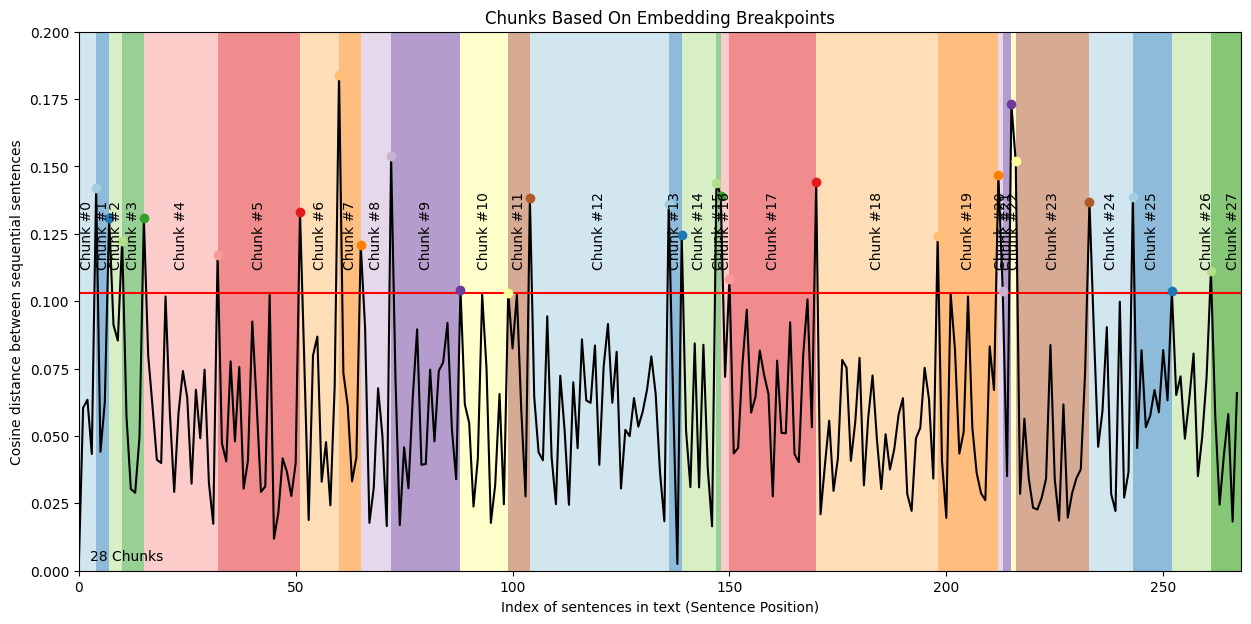

In [5]:
plot_chunking (distances,90) # plot chunks

### Agentic Splitting

In [12]:
from agentic_chunking import proposal_indexing, extract_list
from semantic_chunking import chunk_text
import transformers
import torch

In [ ]:
chunk_size = 2048 #1024

# load llm model
model_id = "meta-llama/Meta-Llama-3-8B-Instruct"

pipeline = transformers.pipeline(
    "text-generation",
    model=model_id,
    model_kwargs={"torch_dtype": torch.bfloat16},
    device_map="cuda:0",
    max_new_tokens=4000,
)

#prompt 
prompt = 'System: Decompose the "Content" into clear and simple propositions, ensuring they are interpretable out of context. \n 1. Split compound sentence into simple sentences. Maintain the original phrasing from the input whenever possible. \n 2. For any named entity that is accompanied by additional descriptive information, separate this information into its own distinct proposition. \n 3. Decontextualize the proposition by adding necessary modifier to nouns or entire sentences and replacing pronouns (e.g., "it", "he", "she", "they", "this", "that") with the full name of the entities they refer to. \n 4. Present the results as a list of strings, formatted in JSON. \n Example: Input: Title: ¯Eostre. Section: Theories and interpretations, Connection to Easter Hares. Content: The earliest evidence for the Easter Hare (Osterhase) was recorded in south-west Germany in 1678 by the professor of medicine Georg Franck von Franckenau, but it remained unknown in other parts of Germany until the 18th century. Scholar Richard Sermon writes that "hares were frequently seen in gardens in spring, and thus may have served as a convenient explanation for the origin of the colored eggs hidden there for children. Alternatively, there is a European tradition that hares laid eggs, since a hare’s scratch or form and a lapwing’s nest look very similar, and both occur on grassland and are first seen in the spring. In the nineteenth century the influence of Easter cards, toys, and books was to make the Easter Hare/Rabbit popular throughout Europe. German immigrants then exported the custom to Britain and America where it evolved into the Easter Bunny." Output: [ "The earliest evidence for the Easter Hare was recorded in south-west Germany in 1678 by Georg Franck von Franckenau.", "Georg Franck von Franckenau was a professor of medicine.", "The evidence for the Easter Hare remained unknown in other parts of Germany until the 18th century.", "Richard Sermon was a scholar.", "Richard Sermon writes a hypothesis about the possible explanation for the connection between hares and the tradition during Easter", "Hares were frequently seen in gardens in spring.", "Hares may have served as a convenient explanation for the origin of the colored eggs hidden in gardens for children.", "There is a European tradition that hares laid eggs.", "A hare’s scratch or form and a lapwing’s nest look very similar.", "Both hares and lapwing’s nests occur on grassland and are first seen in the spring.", "In the nineteenth century the influence of Easter cards, toys, and books was to make the Easter Hare/Rabbit popular throughout Europe.", "German immigrants exported the custom of the Easter Hare/Rabbit to Britain and America.", "The custom of the Easter Hare/Rabbit evolved into the Easter Bunny in Britain and America."]'
history_bot = 'I will output only the results as one line of list of strings, formatted in JSON.'

docs = []

data = [d.replace("= \n", " : ") for d in data] 

for i, d in enumerate(data[10:100]):
    paragraphs = d.split("\n =")
    print(i)
    
    for para in paragraphs :
        if len(para)> chunk_size :

            para= extract_list(proposal_indexing(para, pipeline, prompt, history_bot)) # extract proposition
            _, _, chunks, _ = chunk_text(para, model_name_embed="BAAI/bge-small-en", breakpoint_percentile_threshold=90, chunk_size=None, split=False) # split using semantic chunking

            docs.extend([Document(text = chunk, metadata = {"doc_id" : i }) for chunk in chunks])
        else :   
            docs.append(Document(text = para, metadata = {"doc_id" : i }))

### With llm

In [14]:
from agentic_chunking import proposal_indexing, extract_list
import re
import ast

In [15]:
import transformers
import torch

#load llm
model_id = "meta-llama/Meta-Llama-3-8B-Instruct"

pipeline = transformers.pipeline(
    "text-generation",
    model=model_id,
    model_kwargs={"torch_dtype": torch.bfloat16},
    device_map="auto",
)


/mnt/nvme/home/durech/camille/rag/lib/python3.10/site-packages/accelerate/utils/modeling.py:1381: UserWarning: Current model requires 4096 bytes of buffer for offloaded layers, which seems does not fit any GPU's remaining memory. If you are experiencing a OOM later, please consider using offload_buffers=True.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:00<00:00,  5.59it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [16]:
def chunks_and_summarize(text) :
    """
    Decomposes a given text into clear, decontextualized segments of up to 500 words, focusing on specific topics or themes. 
    The function modifies the text by replacing pronouns and other context-dependent elements to make each segment stand alone.

    Args:
        text (str): The input text to be decomposed into segments.

    Returns:
        str: A list of JSON-formatted strings, where each string is a decontextualized segment of the input text, centered around specific topics or themes.
    """
    messages = []
    
    history_user = 'Decompose the following text into clear segments of a maximum of 500 words, each centered around specific topics or themes. Each segments should be interpretable out of context. Decontextualize the paragraphs by adding necessary modifier to nouns or entire sentences and replacing pronouns (e.g., "it", "he", "she", "they", "this", "that") with the full name of the entities they refer to. Present the results as a list of strings, formatted in JSON. \n Exemple : Text : Germany is the seventh-largest country in Europe; bordering Denmark to the north, Poland and the Czech Republic to the east, Austria to the southeast, and Switzerland to the south-southwest. France, Luxembourg and Belgium are situated to the west, with the Netherlands to the northwest. Germany is also bordered by the North Sea and, at the north-northeast, by the Baltic Sea. German territory covers 357,600 km2, consisting of 349,250 km2 of land and 8,350 km2 of water. Elevation ranges from the mountains of the Alps in the south to the shores of the North Sea in the northwest and the Baltic Sea (Ostsee) in the northeast. The forested uplands of central Germany and the lowlands of northern Germany are traversed by major rivers as the Rhine, Danube and Elbe. Significant natural resources include iron ore, coal, potash, timber, lignite, uranium, copper, natural gas, salt, and nickel. \n Output : ["Germany is the seventh-largest country in Europe. Germany is the seventh-largest country in Europe; bordering Denmark to the north, Poland and the Czech Republic to the east, Austria to the southeast, and Switzerland to the south-southwest. France, Luxembourg and Belgium are situated to the west, with the Netherlands to the northwest. Germany is also bordered by the North Sea and, at the north-northeast, by the Baltic Sea.", "content": "German territory covers 357,600 km², consisting of 349,250 km² of land and 8,350 km² of water. Elevation in Germany ranges from the mountains of the Alps in the south to the shores of the North Sea in the northwest and the Baltic Sea in the northeast. The forested uplands of central Germany and the lowlands of northern Germany are traversed by major rivers such as the Rhine, Danube, and Elbe.", "Significant natural resources in Germany include iron ore, coal, potash, timber, lignite, uranium, copper, natural gas, salt, and nickel."]'
    history_bot = 'I will output only the results as one line of list of strings, formatted in JSON.'

    # history_user = ["Could you please divide a given text into segments of maximum 500 words, each centered around specific topics or themes? For each segment, start by a short introduction allowing each part to stand independently."]

    messages.append({"role": "user", "content": str(history_user)})
    messages.append({"role": "system", "content": str(history_bot)})
    messages.append({"role": "user", "content": "Text : "  + str(text) + "\n Output : "})

    terminators = [
        pipeline.tokenizer.eos_token_id,
        pipeline.tokenizer.convert_tokens_to_ids("<|eot_id|>")
    ]

    outputs = pipeline(
        messages,
        eos_token_id=terminators,
        do_sample=True,
        temperature=0.6,
        top_p=0.9,
        max_new_tokens=2000,
    )
    return outputs[0]["generated_text"][-1]

def extract_list(output):
    """
    Extracts and returns a list of decontextualized segments from the generated output.

    Args:
        output (dict): A dictionary containing the generated text from the chunks_and_summarize function.

    Returns:
        list: A Python list of strings extracted from the generated text, formatted as a JSON list.

    Example:
        Input:
        output = {
            "content": '["Segment 1 content", "Segment 2 content"]'
        }

        Output:
        ["Segment 1 content", "Segment 2 content"]
    """
    content = output["content"].strip()#["content"] #.strip()
    
    if content[0]!= "[" :
        match = re.search(r'\[\s*(".*?"\s*(?:,\s*".*?"\s*)*)\]', content, re.DOTALL)
        if match:
            content = "[" + match.group(1) +"]"
            
    if content[-1] != ']':
        content = content + "]"
        
    
    actual_list = ast.literal_eval(content)
    return actual_list

# output = chunks_and_summarize(data[0][0:500])

In [17]:
chunk_size = 2048
docs=[]
data = [d.replace("= \n", " : ") for d in data] 
for i, d in enumerate(data):
    paragraphs = d.split("\n =")
    print(i)
    
    for para in paragraphs : # for each paragraph
        # print(len(para))
        if len(para)> chunk_size : # if superior to a chunk size, split it
            chunks= extract_list(chunks_and_summarize(para)) #ask llm to split text
            docs.extend([Document(text = chunk, metadata = {"doc_id" : i }) for chunk in chunks])
        else :   
            docs.append(Document(text = para, metadata = {"doc_id" : i }))